In [1]:
%%capture
!pip install torch torchvision tqdm

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = 'cuda:0'
else: device = 'cpu'
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

print(device)


MPS not available because the current PyTorch install was not built with MPS enabled.
cuda:0


In [3]:
from google.colab import drive

drive.mount('/content/drive/')

PATH = "/content/drive/MyDrive/18.065 Project"
! mkdir ./data
! cp -r "{PATH}/data/ILSVRC2012_img_val.tar" ./data
! cp -r "{PATH}/data/ILSVRC2012_devkit_t12.tar.gz" ./data

import os
# os.mkdir(f"{PATH}/models")
# os.chdir(PATH)

Mounted at /content/drive/


# Predefined Models


In [4]:
class SimpleFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 120),
          nn.Linear(120, 84),
          nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

class LargeFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 128),
          nn.Linear(128, 512),
          nn.Linear(512, 2048),
          nn.Linear(2048, 8192),
          nn.Linear(8192, 2048),
          nn.Linear(2048, 512),
          nn.Linear(512, 128),
          nn.Linear(128, 64),
          nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x



# Custom Layers

In [5]:
NUM_SAMPLES = 50
def RandomMatrixMultiplication(x_batch, weight, regular=False, num_samples = None):
    if not num_samples:
      num_samples = int(NUM_SAMPLES)
    #   print(num_samples)
    # print(x_batch.shape)
    # print(weight.shape)
    if regular:
      # samples = torch.arange(x_batch.shape[1], device=device)
      Approx_AB = x_batch @ weight
    else:
      c = num_samples
      p = (torch.norm(x_batch,dim=0) * torch.norm(weight, dim=1))
      # print(p.sum())
      if torch.isinf(p.sum()):
        print(p)
        print(x_batch)
        print(weight)
      p = p/p.sum()
      # if p.sum() < 1e-6:
      #     # print(x_batch)
      #     # print(weight)
      #     pass
      samples = torch.multinomial(p, c, replacement=True).to(device)
      Approx_AB = (1/p[None, samples] * x_batch[:, samples]) @ weight[samples, :]/c
      Approx_AB[Approx_AB>1e10] = 0
      # Approx_AB = x_batch @ weight
          # print(f'Relative Error of |M_{c} - AB|_F/|AB|_F: ', torch.norm(Approx_AB - AB)/torch.norm(AB))
    return Approx_AB

In [6]:
class CustomLinear(nn.Module):
    def __init__(self, weight = None, bias = None):
        super().__init__()
        self.weight = weight
        self.bias = bias

    def set_weights(self, weight, bias):
        self.weight = weight
        self.bias = bias

    def forward(self, x):
        return RandomMatrixMultiplication(x, self.weight.transpose(0,1), regular=True) + self.bias

class RandomizedLinear(nn.Module):
    def __init__(self, weight, bias):
        super().__init__()
        self.weight = weight
        self.bias = bias

    def forward(self, x):
        return RandomMatrixMultiplication(x, self.weight.transpose(0,1)) + self.bias

In [7]:
import torch.nn.functional as F

class ManualConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=False):
        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight = None
        self.bias = None

    def forward(self, x):
        return self.custom_convolution(x)

    def custom_convolution(self, x):
        # x = x.double()
        k = self.k
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        h_out = (h_in + 2 * padding[0] - (k[0] - 1) - 1) / stride[0] + 1
        w_out = (w_in + 2 * padding[1] - (k[1] - 1) - 1) / stride[1] + 1
        h_out, w_out = int(h_out), int(w_out)

        inp_unf = torch.nn.functional.unfold(x, k, padding=padding, stride=stride)

        batch_flattened_inp_unf = inp_unf.transpose(1, 2).reshape(-1, inp_unf.transpose(1, 2).size(2))
        batch_flattened_out_unf = RandomMatrixMultiplication(batch_flattened_inp_unf, self.weight.view(self.weight.size(0), -1).t(), regular = True)
        out_unf = batch_flattened_out_unf.reshape(batch_size, inp_unf.transpose(1, 2).shape[1], -1).transpose(1,2)

        # out_unf = inp_unf.transpose(1, 2).matmul(self.weight.view(self.weight.size(0), -1).t()).transpose(1,2)

        out = torch.nn.functional.fold(out_unf, (h_out, w_out), (1, 1))
        if self.bias is not None:
          out = self.bias[None, :, None, None] + out

        return out

class RandomizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=True):
        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight = None
        self.bias = None

    def forward(self, x):
        return self.custom_convolution(x)

    def custom_convolution(self, x):
        # x = x.double()
        k = self.k
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        h_out = (h_in + 2 * padding[0] - (k[0] - 1) - 1) / stride[0] + 1
        w_out = (w_in + 2 * padding[1] - (k[1] - 1) - 1) / stride[1] + 1
        h_out, w_out = int(h_out), int(w_out)

        inp_unf = torch.nn.functional.unfold(x, k, padding=padding, stride=stride)

        batch_flattened_inp_unf = inp_unf.transpose(1, 2).reshape(-1, inp_unf.transpose(1, 2).size(2))
        batch_flattened_out_unf = RandomMatrixMultiplication(batch_flattened_inp_unf, self.weight.view(self.weight.size(0), -1).t(), regular = False) # Toggle this value to change between randomized and not
        out_unf = batch_flattened_out_unf.reshape(batch_size, inp_unf.transpose(1, 2).shape[1], -1).transpose(1,2)

        # out_unf = inp_unf.transpose(1, 2).matmul(self.weight.view(self.weight.size(0), -1).t()).transpose(1,2)

        out = torch.nn.functional.fold(out_unf, (h_out, w_out), (1, 1))
        if self.bias is not None:
          out = self.bias[None, :, None, None] + out

        return out


# Custom Models


In [8]:
class CustomFCC(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.flatten=nn.Flatten()
        self.layers = nn.Sequential(*[CustomLinear(weight=layer.weight,bias=layer.bias) for layer in net.layers])

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        if not self.training: print(x)
        return x

class RandomizedFCC(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.flatten=nn.Flatten()
        self.layers = nn.Sequential(*[RandomizedLinear(weight=layer.weight,bias=layer.bias) for layer in net.layers])

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        if not self.training: print(x)
        return x


In [9]:
import torchvision.models as models
def replace_layers(net, layer_type, randomized=False):

    for name, module in net.named_children():
        if isinstance(module, layer_type):
            # print(type(module))
            layer = module
            if layer_type == nn.Conv2d:
                weight_matrix = layer.weight.data
                if layer.bias is not None:
                    bias_matrix = layer.bias.data
                if randomized:
                    new = RandomizedConv2d(in_channels=layer.in_channels,
                                          out_channels=layer.out_channels,
                                          kernel_size=layer.kernel_size,
                                          padding=layer.padding,
                                          stride=layer.stride,
                                          bias = True if layer.bias is not None else False)
                    # print('randomized')
                else:
                    new = ManualConv2d(in_channels=layer.in_channels,
                                          out_channels=layer.out_channels,
                                          kernel_size=layer.kernel_size,
                                          padding=layer.padding,
                                          stride=layer.stride,
                                          bias = True if layer.bias is not None else False)
                new.weight = weight_matrix
                if layer.bias is not None:
                    new.bias = bias_matrix
            if layer_type == nn.Linear:
                weight_matrix = layer.weight.data
                if layer.bias is not None:
                    bias_matrix = layer.bias.data
                if randomized:
                    new = RandomizedLinear(weight_matrix, bias_matrix)
                else:
                    new = CustomLinear(weight_matrix, bias_matrix)
            setattr(net, name, new)
        elif len(list(module.children())) > 0:
            replace_layers(module, layer_type, randomized)



# Helper Functions


In [10]:
import torch.optim as optim

def train(model, trainloader, num_epochs):
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          # print(model.device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
  print('Finished Training')

def run_trial(model, testloader, num_trials = 1):
  model.to(device)
  accuracy = []
  times = []
  for _ in range(num_trials):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    total_time = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            outputs = model(images)
            end.record()
            torch.cuda.synchronize()
            total_time += start.elapsed_time(end)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            # print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy.append(correct / total)
    times.append(total_time)
  accuracy = np.array(accuracy)
  times = np.array(times)
  avg_accuracy = np.mean(accuracy)
  std_accuracy = np.std(accuracy)
  avg_runtime = np.mean(times)
  std_runtime = np.std(times)
  print(f'Accuracy (Mean, StD) on the 10000 test images: {100 * avg_accuracy}, {100 * std_accuracy} %')
  print(f'Time (Mean, StD) taken: {avg_runtime}, {std_runtime} %')
  return avg_accuracy, std_accuracy, avg_runtime, std_runtime

def run_experiment(regular_net, randomized_net, testloader, max_samples = 10000):
  global NUM_SAMPLES
  temp = NUM_SAMPLES
  acc_mean_control, acc_std_control, time_mean_control, time_std_control = run_trial(regular_net, testloader, 5)
  acc_mean, acc_std, time_mean, time_std = [], [], [], []
  trials = np.arange(10, max_samples, max_samples/20)
  for t in trials:
      NUM_SAMPLES = t
      result = run_trial(randomized_net, testloader, 20)
      acc_mean.append(result[0])
      acc_std.append(result[1])
      time_mean.append(result[2])
      time_std.append(result[3])

  acc_mean = np.array(acc_mean)
  acc_std = np.array(acc_std)
  time_mean = np.array(time_mean)
  time_std = np.array(time_std)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(trials, acc_mean, color='red', label='Randomized Network')
  ax1.plot(trials, [acc_mean_control] * len(trials), color='blue', label='Regular Network ')
  ax1.fill_between(trials, acc_mean-acc_std, acc_mean+acc_std,
      alpha=0.1, color='red')

  ax1.set_title('Accuracy vs. Num of Samples')
  ax1.set_ylabel('Accuracy (%)')

  ax1.legend(loc="lower right")


  ax2.plot(trials, time_mean, color='red', label='Randomized Network')
  ax2.plot(trials, [time_mean_control] * len(trials), color='blue', label='Regular Network')
  ax2.fill_between(trials, time_mean-time_std, time_mean+time_std,
      alpha=0.1, color='red')
  ax2.fill_between(trials, [time_mean_control - time_std_control] * len(trials), [time_mean_control + time_std_control] * len(trials),
      alpha=0.1, color='blue')

  ax2.set_title('Inference Time vs. Num of Samples')
  ax2.set_xlabel('Variance Retained (%)')
  ax2.set_ylabel('Time (s)')

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)



  plt.show()



# Training/Testing


In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5), (0.5))])

batch_size = 512

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4614489.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134247.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276198.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4500479.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Accuracy (Mean, StD) on the 10000 test images: 91.60000000000001, 0.0 %
Time (Mean, StD) taken: 9.251840007305145, 1.5122156600350123 %
Accuracy (Mean, StD) on the 10000 test images: 13.505999999999998, 0.9077797089602743 %
Time (Mean, StD) taken: 32.984729593992235, 3.5719051294514057 %
Accuracy (Mean, StD) on the 10000 test images: 34.9835, 1.9882436344673664 %
Time (Mean, StD) taken: 33.40487685203552, 6.2517318305343785 %
Accuracy (Mean, StD) on the 10000 test images: 48.758, 2.0901904219472454 %
Time (Mean, StD) taken: 32.35583999752998, 5.37403292173208 %
Accuracy (Mean, StD) on the 10000 test images: 58.35950000000001, 2.113439081213367 %
Time (Mean, StD) taken: 31.35636478662491, 3.88417684174405 %
Accuracy (Mean, StD) on the 10000 test images: 64.05000000000001, 1.3526307700181885 %
Time (Mean, StD) taken: 31.167539209127426, 2.180342248485174 %
Accuracy (Mean, StD) on the 10000 test images: 67.86500000000001, 2.1829212079229983 %
Time (Mean, StD) taken: 35.17399040460587, 7.2

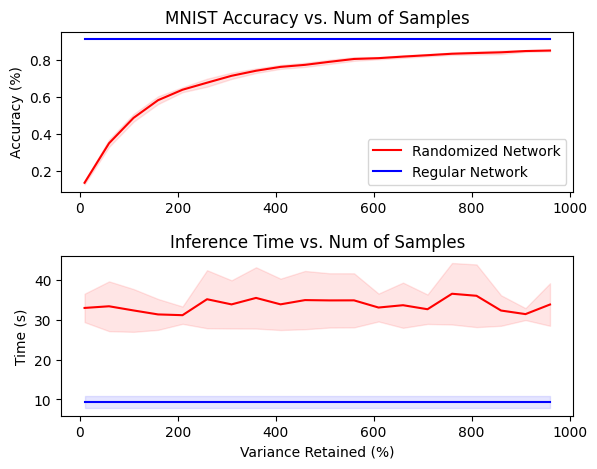

In [24]:
# net = SimpleFCC()
# train(net, trainloader, 10)
# run_trial(net, testloader, 1)
# torch.save(net.state_dict(), f'{PATH}/fcc_model.pth')
# randomized_net = copy.deepcopy(net)
# replace_layers(randomized_net, nn.Linear, True)
# replace_layers(net, nn.Linear, False)
run_experiment(net, randomized_net, testloader, max_samples=1000)


In [19]:
import copy
full_net = LargeFCC()
train(full_net, trainloader, 10)
# net.load_state_dict(torch.load(f'{PATH}/fcc_model.pth'))
randomized_net = copy.deepcopy(net)
replace_layers(randomized_net, nn.Linear, True)
replace_layers(full_net, nn.Linear, False)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 10%|█         | 1/10 [00:06<00:56,  6.28s/it]

[1] loss: 0.038


 20%|██        | 2/10 [00:12<00:50,  6.27s/it]

[2] loss: 0.021


 30%|███       | 3/10 [00:18<00:43,  6.25s/it]

[3] loss: 0.019


 40%|████      | 4/10 [00:25<00:37,  6.26s/it]

[4] loss: 0.019


 50%|█████     | 5/10 [00:31<00:31,  6.24s/it]

[5] loss: 0.019


 60%|██████    | 6/10 [00:37<00:24,  6.25s/it]

[6] loss: 0.018


 70%|███████   | 7/10 [00:43<00:18,  6.27s/it]

[7] loss: 0.018


 80%|████████  | 8/10 [00:50<00:12,  6.25s/it]

[8] loss: 0.018


 90%|█████████ | 9/10 [00:56<00:06,  6.20s/it]

[9] loss: 0.018


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]

[10] loss: 0.018
Finished Training


In [20]:
print(randomized_net)

LargeFCC(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): RandomizedLinear()
    (2): RandomizedLinear()
    (3): RandomizedLinear()
    (4): RandomizedLinear()
    (5): RandomizedLinear()
    (6): RandomizedLinear()
    (7): RandomizedLinear()
    (8): RandomizedLinear()
    (9): RandomizedLinear()
  )
)


Accuracy (Mean, StD) on the 10000 test images: 91.32999999999998, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 62.849229025840756, 0.37891517673997416 %
Accuracy (Mean, StD) on the 10000 test images: 9.724, 0.8259382543507717 %
Time (Mean, StD) taken: 91.49885439872742, 21.53211299025229 %
Accuracy (Mean, StD) on the 10000 test images: 46.937000000000005, 2.24667109297289 %
Time (Mean, StD) taken: 81.68033285140991, 11.25476059628555 %
Accuracy (Mean, StD) on the 10000 test images: 65.088, 1.7676045937935339 %
Time (Mean, StD) taken: 88.51578887701035, 14.01394400633223 %
Accuracy (Mean, StD) on the 10000 test images: 73.75250000000001, 0.8948512446211375 %
Time (Mean, StD) taken: 106.02352662086487, 13.415389660129962 %
Accuracy (Mean, StD) on the 10000 test images: 78.0345, 1.2508656002944523 %
Time (Mean, StD) taken: 113.89434883594512, 1.4572954270394645 %
Accuracy (Mean, StD) on the 10000 test images: 80.925, 1.117656029375764 %
Time (Mean, StD) taken: 132.6618623495102, 5.746

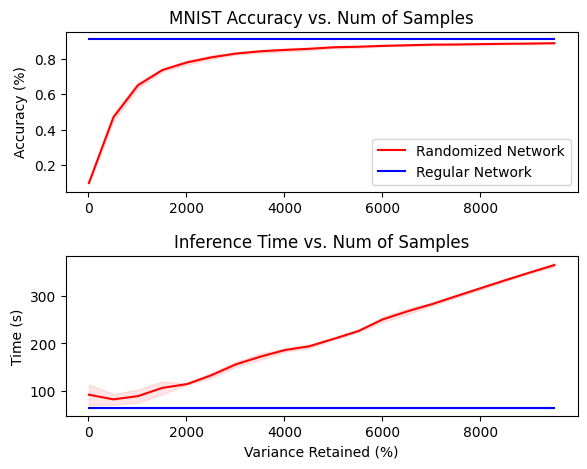

In [22]:
run_experiment(full_net, randomized_net, testloader, max_samples=10000)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 1

trainset = torchvision.datasets.ImageNet(root='./data', transform=transform, split='val')
testset, trainset = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [ ]:
alexnet = models.alexnet(pretrained=True).to(device).eval()
replace_conv_layers(alexnet, '')
randomized_alexnet = models.alexnet(pretrained=True).to(device).eval()
replace_conv_layers(randomized_alexnet, True)

In [ ]:
resnet = models.resnet50(pretrained=True).to(device).eval()
replace_conv_layers(resnet, False)
randomized_resnet = models.resnet50(pretrained=True).to(device).eval()
replace_conv_layers(randomized_resnet, randomized=True)


In [ ]:
densenet = models.densenet121(pretrained=True).to(device).eval()
replace_conv_layers(densenet, False)
randomized_densenet = models.densenet121(pretrained=True).to(device).eval()
replace_conv_layers(randomized_densenet, randomized=True)

Accuracy (Mean, StD) on the 10000 test images: 32.5, 0.0 %
Time (Mean, StD) taken: 618.1748474121093, 1.7934393444482186 %
Accuracy (Mean, StD) on the 10000 test images: 0.07500000000000001, 0.062249497989943656 %
Time (Mean, StD) taken: 462.25811767578125, 0.8061180144838515 %
Accuracy (Mean, StD) on the 10000 test images: 0.10000000000000002, 0.1 %
Time (Mean, StD) taken: 462.2775604248047, 0.9120042303488428 %
Accuracy (Mean, StD) on the 10000 test images: 0.11500000000000002, 0.07262919523166975 %
Time (Mean, StD) taken: 461.8579902648926, 0.9296591208798097 %
Accuracy (Mean, StD) on the 10000 test images: 0.09500000000000001, 0.09205976319760983 %
Time (Mean, StD) taken: 461.520581817627, 0.5406600666498578 %
Accuracy (Mean, StD) on the 10000 test images: 0.08, 0.10295630140987001 %
Time (Mean, StD) taken: 461.80121383666994, 0.855389752538282 %
Accuracy (Mean, StD) on the 10000 test images: 0.09000000000000001, 0.08306623862918075 %
Time (Mean, StD) taken: 461.5633834838867, 0.51

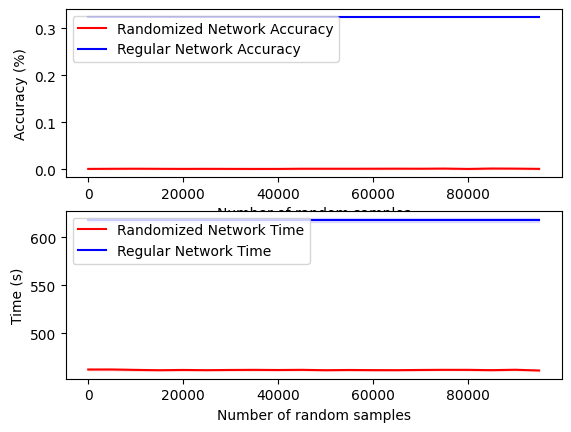

In [156]:
run_experiment(alexnet, randomized_alexnet, trainloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 170MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely l

Accuracy (Mean, StD) on the 10000 test images: 36.0, 0.0 %
Time (Mean, StD) taken: 3064.4680309295654, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 23.1, 0.0 %
Time (Mean, StD) taken: 9999.682624816895, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 36.0, 0.0 %
Time (Mean, StD) taken: 3048.133605051041, 34.188838246520376 %
Accuracy (Mean, StD) on the 10000 test images: 0.09000000000000001, 0.0888819441731559 %
Time (Mean, StD) taken: 6100.492378211022, 63.45571217660512 %
Accuracy (Mean, StD) on the 10000 test images: 8.385000000000002, 0.5452293095569973 %
Time (Mean, StD) taken: 7290.802619838714, 75.93642950802288 %
Accuracy (Mean, StD) on the 10000 test images: 18.555000000000003, 0.8369438451891509 %
Time (Mean, StD) taken: 8639.55407948494, 65.84045496172737 %
Accuracy (Mean, StD) on the 10000 test images: 23.220000000000002, 0.7399999999999997 %
Time (Mean, StD) taken: 9962.818894529342, 69.65067827777253 %
Accuracy (Mean, StD) on the 10000 test images: 26.6400000

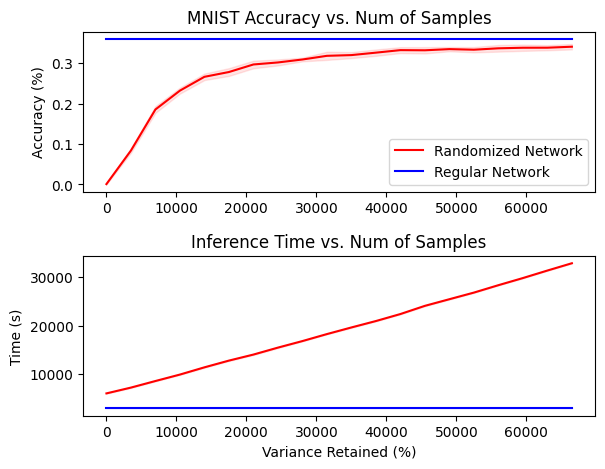

In [13]:
import copy
alexnet = models.alexnet(pretrained=True).to(device).eval()
# # run_trial(alexnet, testloader, 1)
# train(alexnet, trainloader, 2)
randomized_alexnet = copy.deepcopy(alexnet)
replace_layers(alexnet, nn.Conv2d,  False)
replace_layers(randomized_alexnet, nn.Conv2d,  True)
# NUM_SAMPLES = 50000
run_trial(alexnet, testloader, 1)
run_trial(randomized_alexnet, testloader, 1)
run_experiment(alexnet, randomized_alexnet, testloader, max_samples = 70000)


In [ ]:
import copy
densenet = models.densenet121(pretrained=True).to(device).eval()
# # run_trial(alexnet, testloader, 1)
# train(alexnet, trainloader, 2)
randomized_densenet = copy.deepcopy(densenet)
replace_layers(densenet, nn.Conv2d,  False)
replace_layers(randomized_densenet, nn.Conv2d,  True)
# NUM_SAMPLES = 50000
run_trial(densenet, testloader, 1)
run_trial(randomized_densenet, testloader, 1)
run_experiment(densenet, randomized_densenet, testloader, max_samples = 70000)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this wil

Accuracy (Mean, StD) on the 10000 test images: 63.3, 0.0 %
Time (Mean, StD) taken: 41693.48320007324, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 60.5, 0.0 %
Time (Mean, StD) taken: 569740.2954711914, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 63.3, 0.0 %
Time (Mean, StD) taken: 41512.252895355225, 348.14907367367675 %
Accuracy (Mean, StD) on the 10000 test images: 0.085, 0.07262919523166976 %
Time (Mean, StD) taken: 117933.12177963257, 836.1446638375563 %
Accuracy (Mean, StD) on the 10000 test images: 7.165000000000001, 0.5623833212320578 %
Time (Mean, StD) taken: 137209.5273376465, 552.0405003146013 %
Accuracy (Mean, StD) on the 10000 test images: 30.435000000000002, 0.977893143446666 %
Time (Mean, StD) taken: 159669.75080871582, 757.2425088830577 %
Accuracy (Mean, StD) on the 10000 test images: 43.14, 1.2650691680694788 %
Time (Mean, StD) taken: 182337.75784225465, 1030.8199445270081 %
Accuracy (Mean, StD) on the 10000 test images: 49.13, 0.951892851112982 %
Time 

In [ ]:
run_experiment(densenet, randomized_densenet, testloader)

Accuracy (Mean, StD) on the 10000 test images: 49.800000000000004, 5.551115123125783e-15 %
Time (Mean, StD) taken: 13393.55566444397, 154.01223485948347 %
Accuracy (Mean, StD) on the 10000 test images: 0.11, 0.1044030650891055 %
Time (Mean, StD) taken: 32125.077034187318, 218.53602269536347 %
Accuracy (Mean, StD) on the 10000 test images: 0.15500000000000003, 0.13219304066402288 %
Time (Mean, StD) taken: 32350.160330200197, 221.19389589853287 %
Accuracy (Mean, StD) on the 10000 test images: 2.620000000000001, 0.4610856753359402 %
Time (Mean, StD) taken: 32362.699859905242, 168.62607106103755 %
Accuracy (Mean, StD) on the 10000 test images: 8.279999999999998, 0.5887274411814012 %
Time (Mean, StD) taken: 32414.71282777786, 269.3556775773805 %
Accuracy (Mean, StD) on the 10000 test images: 15.330000000000002, 0.6140846847137619 %
Time (Mean, StD) taken: 32538.488830947877, 233.99222850096652 %
Accuracy (Mean, StD) on the 10000 test images: 21.955000000000005, 0.8357481678113331 %
Time (Me

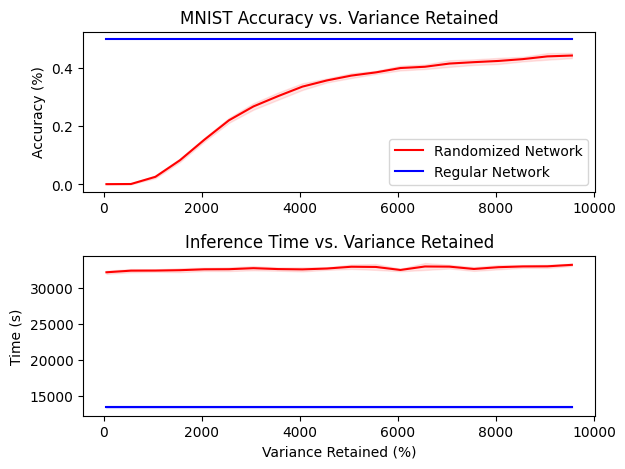

In [54]:
# import copy
# resnet = models.resnet50(pretrained=True).to(device).eval()
# # run_trial(alexnet, testloader, 1)
# train(resnet, trainloader, 5)
# randomized_resnet = copy.deepcopy(resnet)
# control_resnet = copy.deepcopy(resnet)

# replace_layers(resnet, nn.Conv2d,  False)
# replace_layers(randomized_resnet, nn.Conv2d,  True)

# NUM_SAMPLES = 20000
# run_trial(resnet, testloader, 1)
# run_trial(randomized_resnet, testloader, 1)

run_experiment(resnet, randomized_resnet, testloader)



In [27]:
# import copy
# densenet = models.densenet121(pretrained=True).to(device).eval()
# # run_trial(alexnet, testloader, 1)
# train(densenet, trainloader, 5)
# randomized_densenet = copy.deepcopy(densenet)
# control_densenet = copy.deepcopy(densenet)

# replace_layers(densenet, nn.Conv2d,  False)
# replace_layers(randomized_densenet, nn.Conv2d,  True)

# NUM_SAMPLES = 20000
# run_trial(densenet, testloader, 1)
# run_trial(randomized_densenet, testloader, 1)
device = 'cpu'
!export CUDA_LAUNCH_BLOCKING=1
run_experiment(densenet, randomized_densenet, testloader, max_samples = 10000)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
